## Cell DS-0 — Paths & basic setup

In [ ]:
# DS-0: paths & basic setup
from pathlib import Path

SAVE_TO_PAPER = True  # Set to False to save in local images folder

if SAVE_TO_PAPER:
    IMG_DIR = Path('../../paper/figs')
else:
    IMG_DIR = Path.cwd() / 'images'
IMG_DIR.mkdir(parents=True, exist_ok=True)

FIG_FRINGES = str(IMG_DIR / 'double_slit_fringes.png')
FIG_SHIFT   = str(IMG_DIR / 'double_slit_shift.png')

print('Saving figures to:')
print('  ', FIG_FRINGES)
print('  ', FIG_SHIFT)

Saving figures to:
   c:\workspace\Physics\X-theta-framework\notebooks\images\double_slit_fringes.png
   c:\workspace\Physics\X-theta-framework\notebooks\images\double_slit_shift.png


## Cell DS-1 — Imports, constants, fast grid

In [2]:
# DS-1: imports, constants, fast grid (CPU-only)
import numpy as np
import matplotlib.pyplot as plt
import time

np.set_printoptions(precision=4, suppress=True)
np.random.seed(0)

# ---------- fast-but-accurate defaults (adjust later if needed) ----------
NX, NY, NZ  = 48, 1, 64     # collapse y to 1 → 2D (x,z) physics
NTHETA      = 12

X_MAX, Y_MAX, Z_MAX = 5.0, 0.1, 5.0  # tiny Y box since NY=1

DT    = 2.0e-3
T_END = 1.20
STEPS = int(T_END / DT)

# physics (dimensionless)
hbar = 1.0
M    = 1.0
#I    = 1.0
I_theta = 1.0   # moment of inertia for θ
Q    = 0.4

# one-time cleanup of any leaked globals named 'I'
globals().pop('I', None)

# initial packet (z-direction)
z0   = -2.5
k0z  = 3.0       # group velocity = hbar*k0z/M = 3.0
sigma_xyz = 0.5


## Cell DS-2 — Grids, volume, fields

In [3]:
# DS-2: grids, volume, fields
x = np.linspace(-X_MAX, X_MAX, NX); dx = x[1]-x[0]
y = np.linspace(-Y_MAX, Y_MAX, NY); dy = y[1]-y[0] if NY > 1 else 1.0
z = np.linspace(-Z_MAX, Z_MAX, NZ); dz = z[1]-z[0]
theta = np.linspace(-np.pi, np.pi, NTHETA, endpoint=False); dtheta = theta[1]-theta[0]

XX, YY, ZZ, TTH = np.meshgrid(x, y, z, theta, indexing="ij")
vol = dx * dy * dz * dtheta

# A_theta(x) MUST be 3-D (no theta axis)
A_theta_3d = 0.25 * XX[..., 0]   # shape: (NX,NY,NZ) with NY=1
assert A_theta_3d.shape == (NX, NY, NZ)

# sanity checks
assert A_theta_3d.shape == (NX, NY, NZ)
assert isinstance(NTHETA, int) and NTHETA == theta.size



## Cell DS-3 — Kinetic operators (θ minimal coupling later)

In [4]:
# DS-3: kinetic operators for XYZ and theta
# XYZ momentum grid
kx = 2*np.pi*np.fft.fftfreq(NX, d=dx)
ky = 2*np.pi*np.fft.fftfreq(NY, d=dy) if NY > 1 else np.array([0.0])
kz = 2*np.pi*np.fft.fftfreq(NZ, d=dz)
KKX, KKY, KKZ = np.meshgrid(kx, ky, kz, indexing="ij")

Hk_xyz       = (hbar**2/(2*M))*(KKX**2 + KKY**2 + KKZ**2)
U_K_xyz_half = np.exp(-1j*(DT/2)*Hk_xyz/hbar)  # (NX,NY,NZ)

# theta Fourier modes (1-D vector)
#m_vec = np.fft.fftfreq(NTHETA, d=1.0/NTHETA).astype(float)   # shape: (NTHETA,)

# DS-3 (patch): use a unique name for theta modes
m_theta = np.fft.fftfreq(NTHETA, d=1.0/NTHETA).astype(float)   # shape: (NTHETA,)
assert m_theta.shape == (NTHETA,)



## Cell DS-4 — Double-slit barrier, absorbers (CAP), initial ψ, helpers

In [5]:
# DS-4: double-slit barrier, CAP, initial psi, helpers

# ---- Double-slit geometry ----
z_slit       = 0.0
z_idx_slit   = np.argmin(np.abs(z - z_slit))
w_slit       = 0.6        # slit width in x
sep_slits    = 2.0        # separation between slit centers
thick_planes = 2          # number of z slices with barrier

# Build barrier V(x,y,z): high except two x windows (slits) through the plane(s)
V_bar = np.zeros((NX,NY,NZ), dtype=complex)
V0    = 120.0             # high but not absurd (keeps CPU fast)

z_planes = [np.clip(z_idx_slit + k, 0, NZ-1) for k in range(-(thick_planes//2), (thick_planes//2)+1)]
for zi in z_planes:
    mask_bar = np.ones((NX,NY), dtype=bool)

    x_left_center  = -sep_slits/2.0
    x_right_center = +sep_slits/2.0

    left_open  = (np.abs(x[:,None]-x_left_center)  <= w_slit/2.0)  # (NX,1)
    right_open = (np.abs(x[:,None]-x_right_center) <= w_slit/2.0)  # (NX,1)
    open_mask  = np.logical_or(left_open, right_open)              # (NX,1)

    mask_bar[open_mask.repeat(NY, axis=1)] = False
    V_bar[..., zi] = np.where(mask_bar, V0, 0.0)

# ---- Complex absorbing potential (separable) ----
def smooth_cap(axis_len, frac=0.12):
    n = int(axis_len*frac)
    w = np.zeros(axis_len)
    if n > 0:
        ramp = 0.5*(1 - np.cos(np.linspace(0, np.pi, n)))
        w[:n]  = ramp
        w[-n:] = ramp[::-1]
    return w

eta = 3.0
Wx = smooth_cap(NX, frac=0.12)
Wy = smooth_cap(NY, frac=0.12) if NY > 1 else np.zeros(1)
Wz = smooth_cap(NZ, frac=0.12)
CAP = -1j*eta*(Wx[:,None,None] + Wy[None,:,None] + Wz[None,None,:])

V_tot = V_bar + CAP  # total potential (complex), shape: (NX,NY,NZ)

# ---- initial packet: Gaussian at z0 with forward momentum k0z ----
psi_xyz0 = np.exp(-((XX**2 + YY**2 + (ZZ - z0)**2)/(2*sigma_xyz**2))) * np.exp(1j*k0z*(ZZ - z0))

def normalize(psi):
    return psi / np.sqrt(np.sum(np.abs(psi)**2)*vol)

def exp_kin_xyz(psi, U_half):
    """
    Apply e^{-i (DT/2) T_xyz / ħ} with FFTs.
    If NY==1, only FFT over (x,z) to accelerate.
    """
    if psi.shape[1] == 1:
        psi_k = np.fft.fftn(psi, axes=(0,2))          # (x,z) only
        psi_k *= U_half[:, :, :][..., None]           # broadcast over theta
        return np.fft.ifftn(psi_k, axes=(0,2))
    else:
        psi_k = np.fft.fftn(psi, axes=(0,1,2))
        psi_k *= U_half[..., None]
        return np.fft.ifftn(psi_k, axes=(0,1,2))

def theta_kinetic_step(psi, dt, use_coupling=True):
    """
    Minimal coupling along θ:
      Uθ = exp[-i dt/(2 Iθ ħ) (ħ m - Q Aθ(x))^2]
    Baseline QM: exp[-i dt/(2 Iθ ħ) (ħ m)^2]
    """
    assert psi.ndim == 4, f"psi must be (NX,NY,NZ,NTHETA), got {psi.shape}"
    NX_, NY_, NZ_, NTHETA_ = psi.shape
    assert np.isscalar(I_theta), "I_theta must be a scalar"

    # θ modes (local, bullet-proof)
    m_theta_vec = np.fft.fftfreq(NTHETA_, d=1.0/NTHETA_).astype(float)
    m = m_theta_vec.reshape(1,1,1,-1)  # (1,1,1,NTHETA)

    # A_theta broadcast
    a = (Q * A_theta_3d)[..., None]    # (NX,NY,NZ,1)
    assert a.shape == (NX_,NY_,NZ_,1)

    psi_m = np.fft.fft(psi, axis=3)
    if use_coupling:
        phase = (hbar*m - a)**2
    else:
        phase = (hbar*m)**2

    U_th = np.exp(-1j * dt * phase / (2 * I_theta * hbar))
    psi_m *= U_th
    return np.fft.ifft(psi_m, axis=3)



def evolve_one_step(psi, U_V_half, *, use_coupling=True):
    psi = U_V_half * psi
    psi = exp_kin_xyz(psi, U_K_xyz_half)
    psi = theta_kinetic_step(psi, DT, use_coupling=use_coupling)
    psi = exp_kin_xyz(psi, U_K_xyz_half)
    psi = U_V_half * psi
    return psi

def make_initial(m0):
    psi_th0 = np.exp(-(TTH**2)/(2*0.5**2)) * np.exp(1j*m0*TTH)
    psi0    = normalize(psi_xyz0 * psi_th0)
    U_V_half = np.exp(-1j*(DT/2)*V_tot/hbar)[..., None]  # broadcast over theta
    return psi0, U_V_half

def screen_intensity(psi, z_index):
    """
    Return I(x) = ∫ dy dθ |ψ(x,y,z_index,θ)|^2.
    Works for NY==1 (collapsed y) or NY>1.
    """
    sl = np.abs(psi[:, :, z_index, :])**2   # shape: (NX, NY, NTHETA) when NY>=1
    # Sum over all axes except the first (x):
    axes_to_sum = tuple(range(1, sl.ndim))
    I_x = np.sum(sl, axis=axes_to_sum) * (dy * dtheta)  # dy==1.0 when NY==1
    return I_x.real



## Cell DS-5 — Runner with early stop + progress

In [6]:
# DS-5: run to the screen with progress prints and early stop
def run_double_slit(m0, *, use_coupling=True, measure_z=+2.5, status_every=100):
    psi, U_V_half = make_initial(m0)
    z_idx_screen = np.argmin(np.abs(z - measure_z))

    # time-of-flight to screen
    v_g     = hbar*k0z/M
    flight  = (measure_z - z0) / max(v_g, 1e-9)
    steps_needed = max(5, int(flight/DT) + int(0.10/DT))  # add small cushion

    t0 = time.time()
    for step in range(min(STEPS, steps_needed)):
        psi = evolve_one_step(psi, U_V_half, use_coupling=use_coupling)
        if step % status_every == 0:
            prob = np.sum(np.abs(psi)**2) * vol
            elapsed = time.time() - t0
            print(f"  step {step:5d}/{steps_needed}, elapsed={elapsed:5.1f}s, norm≈{prob:.4f}")

    I_x = screen_intensity(psi, z_idx_screen)
    secs = time.time() - t0
    return I_x, x, secs

def normalize_profile(I, x):
    area = np.trapezoid(I, x)  # replaces np.trapz
    return I / area if area > 0 else I



## Cell DS-6 — Quick single-run sanity (X–θ m0=+2)

  step     0/883, elapsed=  0.0s, norm≈1.0000
  step    50/883, elapsed=  0.4s, norm≈1.0000
  step   100/883, elapsed=  0.8s, norm≈1.0000
  step   150/883, elapsed=  1.2s, norm≈1.0000
  step   200/883, elapsed=  1.6s, norm≈1.0000
  step   250/883, elapsed=  2.0s, norm≈1.0000
  step   300/883, elapsed=  2.3s, norm≈0.9999
  step   350/883, elapsed=  2.7s, norm≈0.9998
  step   400/883, elapsed=  3.0s, norm≈0.9995
  step   450/883, elapsed=  3.3s, norm≈0.9983
  step   500/883, elapsed=  3.6s, norm≈0.9950
  step   550/883, elapsed=  3.9s, norm≈0.9894
Single X–θ (m0=+2) finished in 4.2s


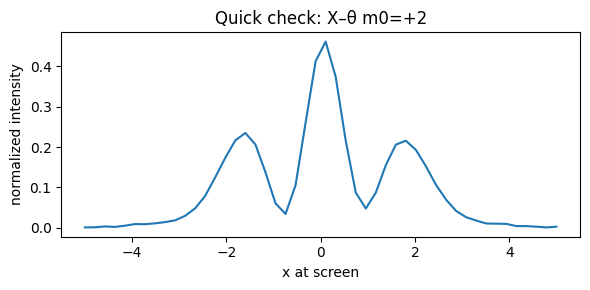

In [7]:
# DS-6: sanity single run (progress should print within seconds)
I_single, xgrid_single, secs_single = run_double_slit(+2, use_coupling=True, measure_z=+2.5, status_every=50)
print(f"Single X–θ (m0=+2) finished in {secs_single:.1f}s")

plt.figure(figsize=(6,3))
plt.plot(xgrid_single, normalize_profile(I_single, xgrid_single))

plt.xlabel("x at screen")
plt.ylabel("normalized intensity")
plt.title("Quick check: X–θ m0=+2")
plt.tight_layout()
plt.show()


## Cell DS-7 — Full comparison: X–θ (m0=±2,0) vs QM baseline

  step     0/883, elapsed=  0.0s, norm≈1.0000
  step    80/883, elapsed=  0.5s, norm≈1.0000
  step   160/883, elapsed=  1.0s, norm≈1.0000
  step   240/883, elapsed=  1.4s, norm≈1.0000
  step   320/883, elapsed=  1.8s, norm≈0.9999
  step   400/883, elapsed=  2.2s, norm≈0.9995
  step   480/883, elapsed=  2.7s, norm≈0.9965
  step   560/883, elapsed=  3.1s, norm≈0.9878
X–θ m0=+2     runtime=3.3s
  step     0/883, elapsed=  0.0s, norm≈1.0000
  step    80/883, elapsed=  0.4s, norm≈1.0000
  step   160/883, elapsed=  0.9s, norm≈1.0000
  step   240/883, elapsed=  1.3s, norm≈1.0000
  step   320/883, elapsed=  1.7s, norm≈0.9999
  step   400/883, elapsed=  2.1s, norm≈0.9995
  step   480/883, elapsed=  2.6s, norm≈0.9965
  step   560/883, elapsed=  3.0s, norm≈0.9878
X–θ m0=  0    runtime=3.2s
  step     0/883, elapsed=  0.0s, norm≈1.0000
  step    80/883, elapsed=  0.4s, norm≈1.0000
  step   160/883, elapsed=  0.9s, norm≈1.0000
  step   240/883, elapsed=  1.3s, norm≈1.0000
  step   320/883, elapsed=

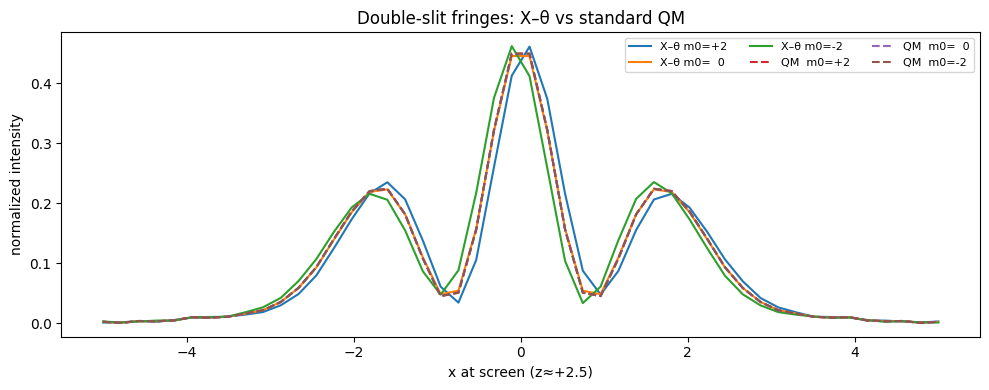

In [8]:
# DS-7: full set of cases with normalized profiles
cases = [
    ("X–θ m0=+2", +2, True),
    ("X–θ m0=  0",  0, True),
    ("X–θ m0=-2", -2, True),
    ("QM  m0=+2", +2, False),
    ("QM  m0=  0",  0, False),
    ("QM  m0=-2", -2, False),
]

profiles = {}
for label, m0, use_cpl in cases:
   # I, xgrid, secs = run_double_slit(m0, use_coupling=use_cpl, measure_z=+2.5, status_every=80)
    I_scr, xgrid, secs = run_double_slit(m0, use_coupling=use_cpl, measure_z=+2.5, status_every=80)

    #I_norm = I / np.trapz(I, xgrid)
    I_norm = normalize_profile(I_scr, xgrid)

    profiles[label] = (xgrid, I_norm)
    print(f"{label:12s}  runtime={secs:.1f}s")

plt.figure(figsize=(10,4))
for label in ["X–θ m0=+2","X–θ m0=  0","X–θ m0=-2"]:
    xg, Ig = profiles[label]
    plt.plot(xg, Ig, label=label)

for label in ["QM  m0=+2","QM  m0=  0","QM  m0=-2"]:
    xg, Ig = profiles[label]
    plt.plot(xg, Ig, ls="--", label=label)

plt.xlabel("x at screen (z≈+2.5)")
plt.ylabel("normalized intensity")
plt.title("Double-slit fringes: X–θ vs standard QM")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.savefig(FIG_FRINGES, dpi=160)
plt.show()


## Cell DS-8 — Fringe-center shift metric

Center fringe shifts (relative to m0=0):
  X–θ: Δx(+2)= +7.6090e-02,  Δx(-2)= -7.7993e-02
  QM : Δx(+2)= +1.8551e-15,   Δx(-2)= +1.9471e-15


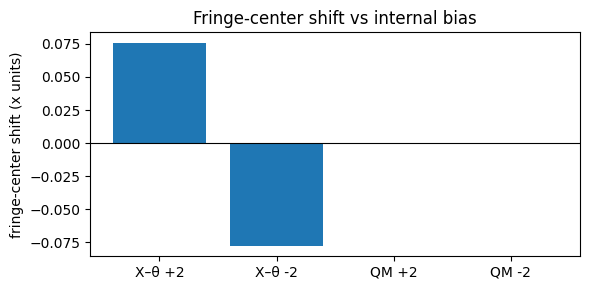

In [9]:
# DS-8: measure fringe-center shift relative to m0=0
def peak_x(xg, Ig):
    idx = np.argmax(Ig)
    if 0 < idx < len(Ig)-1:
        # quadratic subpixel fit (parabola through 3 points)
        x1,x2,x3 = xg[idx-1], xg[idx], xg[idx+1]
        y1,y2,y3 = Ig[idx-1], Ig[idx], Ig[idx+1]
        denom = (x1-x2)*(x1-x3)*(x2-x3)
        if abs(denom) > 1e-14:
            A = (x3*(y2-y1) + x2*(y1-y3) + x1*(y3-y2)) / denom
            B = (x3**2*(y1-y2) + x2**2*(y3-y1) + x1**2*(y2-y3)) / denom
            if A != 0:
                return -B/(2*A)
    return xg[idx]

def center_shift(profiles_dict, pref):
    x_plus  = peak_x(*profiles_dict[f"{pref} m0=+2"])
    x_zero  = peak_x(*profiles_dict[f"{pref} m0=  0"])
    x_minus = peak_x(*profiles_dict[f"{pref} m0=-2"])
    return x_plus - x_zero, x_minus - x_zero

dx_plus_theta, dx_minus_theta = center_shift(profiles, "X–θ")
dx_plus_qm,    dx_minus_qm    = center_shift(profiles, "QM ")

print("Center fringe shifts (relative to m0=0):")
print(f"  X–θ: Δx(+2)= {dx_plus_theta:+.4e},  Δx(-2)= {dx_minus_theta:+.4e}")
print(f"  QM : Δx(+2)= {dx_plus_qm:+.4e},   Δx(-2)= {dx_minus_qm:+.4e}")

plt.figure(figsize=(6,3))
labels = ["X–θ +2","X–θ -2","QM +2","QM -2"]
vals   = [dx_plus_theta, dx_minus_theta, dx_plus_qm, dx_minus_qm]
plt.bar(labels, vals)
plt.axhline(0, lw=0.8, color='k')
plt.ylabel("fringe-center shift (x units)")
plt.title("Fringe-center shift vs internal bias")
plt.tight_layout()
plt.savefig(FIG_SHIFT, dpi=160)
plt.show()


In [ ]:
# Save plot to Paper/figs using style.savefig
import sys
sys.path.append('../src/plot')
import style
style.savefig('../../paper/figs/double_slit_diagnostics.png')